# DOGBREED CLASSIFICATION

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.session import TrainingInput
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import torch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

Dog breed dataset consist of dog images of different breeds, which was alrready labeled.

Dataset has following folder structure:
 - test (test images)
 - train (train images)
 - valid (validation images)
 
File name example:\
 ```/test/001.Affenpinscher/Affenpinscher_00003.jpg```
 

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [3]:
session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

prefix = "dogImages"

Default Bucket: sagemaker-eu-central-1-292065287762
AWS Region: eu-central-1
RoleArn: arn:aws:iam::292065287762:role/service-role/AmazonSageMaker-ExecutionRole-20220106T213772


In [ ]:
# Upload files to s3
# import os

# os.environ["DEFAULT_S3_BUCKET"] = bucket
# !aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/
inputs = session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("S3 path: {}".format(inputs))

In [ ]:
# Delete "dogImages" folder
!rm -r dogImages
!rm dogImages.zip

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
inputs = f"s3://{bucket}/{prefix}"
print(inputs)

s3://sagemaker-eu-central-1-292065287762/dogImages


In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([128, 256, 512]),
    "model": CategoricalParameter(["resnet18", "resnet34"])
}

In [6]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
#TODO: Create estimators for your HPs
# For development use ml.m5.large and for training ml.g4dn.xlarge

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [8]:
tuner.fit({"train": inputs + "/train/", "test": inputs + "/test/", "validation": inputs + "/valid/"}) # TODO: Remember to include your data channels

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [9]:
tuner.best_training_job()

'pytorch-training-220213-1633-003-3e3d3335'

In [10]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-02-13 16:57:13 Starting - Preparing the instances for training
2022-02-13 16:57:13 Downloading - Downloading input data
2022-02-13 16:57:13 Training - Training image download completed. Training in progress.
2022-02-13 16:57:13 Uploading - Uploading generated training model
2022-02-13 16:57:13 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'lr': '0.0038930056192024347',
 'model': '"resnet18"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-02-13-16-33-05-958"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"eu-central-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-16-33-05-958/source/sourcedir.tar.gz"'}

In [11]:
best_hyperparameters = best_estimator.hyperparameters()
hyperparameters = {
    "batch-size": int(best_hyperparameters["batch-size"].strip('"')),
    "lr": float(best_hyperparameters["lr"].strip('"')),
    "model": str(best_hyperparameters["model"].strip('"'))
}
hyperparameters

{'batch-size': 128, 'lr': 0.0038930056192024347, 'model': 'resnet18'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=20)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "10",
        "predict.save_interval": "10",
        "global.save_interval": "10",
        "save_interval": "10"
    },
    collection_configs=[
        CollectionConfig(
            name="model_loss",
            parameters={
                "include_regex": ".*CrossEntropyLoss",
                "train.save_interval": "5",
                "eval.save_interval": "1",
                "predict.save_interval": "1",
            },
        )
    ]
)

In [13]:
# TODO: Create and fit an estimator

# uncomment when best estimator hyperparameters not available
hyperparameters = {
    "batch-size": 128,
    "lr": 0.0038930056192024347,
    "model": "resnet18",
    "epochs": 6
}


estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    source_dir='code',
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [14]:
estimator.fit({"train": inputs + "/train/", "test": inputs + "/test/", "validation": inputs + "/valid/"})

2022-02-13 17:16:13 Starting - Starting the training job...
2022-02-13 17:16:15 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-02-13 17:17:40 Starting - Preparing the instances for training......
2022-02-13 17:18:33 Downloading - Downloading input data.........
2022-02-13 17:20:14 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-13 17:21:54,250 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-13 17:21:54,271 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-13 17:21:57,283 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-13 17:21:5

In [15]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")

Training jobname: pytorch-training-2022-02-13-17-16-12-780


In [16]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-02-13 18:23:46.212 1-8-1-cpu-py36-ml-t3-medium-e1aea16d71595229a5f8ea6b9833:134 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-13 18:23:46.239 1-8-1-cpu-py36-ml-t3-medium-e1aea16d71595229a5f8ea6b9833:134 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/debug-output
[2022-02-13 18:23:46.633 1-8-1-cpu-py36-ml-t3-medium-e1aea16d71595229a5f8ea6b9833:134 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 395 more expected)', IncompleteRead(0 bytes read, 395 more expected)) while reading s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [17]:
trial.tensor_names()

[2022-02-13 18:23:58.044 1-8-1-cpu-py36-ml-t3-medium-e1aea16d71595229a5f8ea6b9833:134 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-13 18:23:59.071 1-8-1-cpu-py36-ml-t3-medium-e1aea16d71595229a5f8ea6b9833:134 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_input_0',
 'CrossEntropyLoss_input_1',
 'CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.3.bias',
 'gradient/ResNet_fc.3.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [18]:
trial

<smdebug.trials.s3_trial.S3Trial object at 0x7ff941f70be0>:(
    name=debug-output,
    path=s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/debug-output/,
    steps=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 53, 54, 55, 56, 57, 58, 59, 62, 67, 72, 77, 82, 87, 92, 97, 102, 107, 112, 113, 114, 115, 116, 117, 118, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 173, 174, 175, 176, 177, 178, 179, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 233, 234, 235, 236, 237, 238, 239, 243, 248, 253, 258, 263, 268, 273, 278, 283, 288, 293, 294, 295, 296, 297, 298, 299, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366],
    collections=['default', 'weights', 'biases', 'gradients', 'losses', 'all', 'relu_input', 'model_loss'],
    tensor_names=['CrossEntropyLoss_input_0', 'CrossEntropyLoss_input_1', 'CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0

In [19]:
# TODO: Plot a debugging output.
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.PREDICT)))

64
42
7


In [21]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [22]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


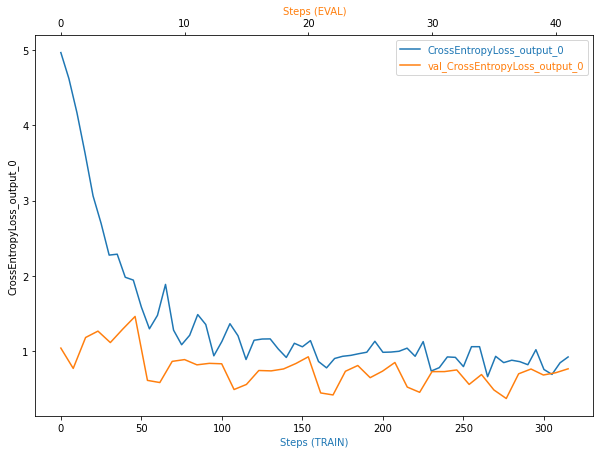

In [23]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

According to chart above loss decreas over the time on both training and validation modes which is good sign.

But according to debug logs during the training 2 errors was found:
 - Overfit: Error
 - Overtraining: IssuesFound
 - PoorWeightInitialization: Error

Overfit might be fixed:
 - by reducing resnet size, for example resnet18 instaead of resnet34
 - by creating more complex fully connected layer with more dropout
 
Overtraining says that 6 epoch probably too long to train this model and we might stop training earlier.
 
Poor weight initialization might be fixed:
 - by adjusting rule parameters, if defaults not fit current use case
 - eventhough that pytorch initialize weights by themself, we can try other technique for that
 - try to tune rule parameters 


In [25]:
# TODO: Display the profiler output
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job = TrainingJob(training_job_name, region)
training_job.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-eu-central-1-292065287762/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 20, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 20, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 20, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 20, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 20, }'}}
s3 path:s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/profiler-output


Profiler data from system is available


In [26]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = training_job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-02-13 18:28:08.487 1-8-1-cpu-py36-ml-t3-medium-e1aea16d71595229a5f8ea6b9833:134 INFO metrics_reader_base.py:134] Getting 16 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [27]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/rule-output


In [28]:
! aws s3 ls {rule_output_path} --recursive

2022-02-13 17:33:27     429132 pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-13 17:33:27     296245 pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-13 17:33:22        553 pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-13 17:33:22      45772 pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-13 17:33:22       1926 pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-13 17:33:22        130 pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-13 17:33:22       5768 pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-re

In [29]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-eu-centra

In [30]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [31]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.p2.xlarge"
) # TODO: Add your deployment configuration like instance type and number of instances

-------------!

In [ ]:
# Re-deploy endpoint from the model
from sagemaker.pytorch.model import PyTorchModel

bucket = 's3://sagemaker-eu-central-1-292065287762/pytorch-training-2022-02-13-17-16-12-780/output/model.tar.gz'
pytorch_model = PyTorchModel(
    model_data=bucket,
    role=role,
    entry_point='train_model.py',
    source_dir='code',
    framework_version="1.8",
    py_version="py36",
)

from sagemaker.predictor import numpy_deserializer, npy_serializer

predictor = pytorch_model.deploy(
    instance_type='ml.p2.xlarge',
    initial_instance_count=1
)

-

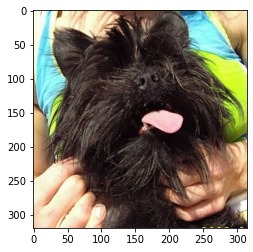

In [42]:
from PIL import Image
file = 'test_img/Affenpinscher_00003.jpg'
image = Image.open(file)
plt.imshow(image)
plt.show()

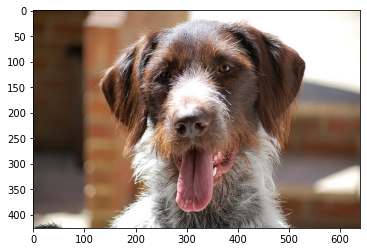

In [46]:
from PIL import Image
file1 = 'test_img/German_wirehaired_pointer_05027.jpg'
image = Image.open(file1)
plt.imshow(image)
plt.show()

In [39]:
# TODO: Run an prediction on the endpoint
image = open(file, 'rb').read()
response = predictor.predict(data=image)
print(response)

['0']


In [47]:
image = open(file1, 'rb').read()
response = predictor.predict(data=image)
print(response)

['72']


In [48]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()